## Импорт библиотек, загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import seaborn as sb
import association_metrics as am
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
import optuna
from sklearn.metrics import mean_absolute_percentage_error as MAPE, mean_absolute_error as MAE, r2_score, mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
from lightgbm import LGBMRanker, LGBMRegressor

In [3]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [4]:
data = pd.read_csv(TRAIN)

## Обзор данных, подготовка к обучению

In [5]:
data.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


In [7]:
data.describe(include='object')

,Company,Specific Bean Origin,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
count,1255,1255,1255,1255,1254,1254
unique,376,762,40,58,38,84
top,Soma,Madagascar,70%,U.S.A.,,Venezuela
freq,35,39,461,521,628,144


Удаляем все строки с пропусками

In [8]:
data.dropna(axis=0, inplace=True)

<Axes: >

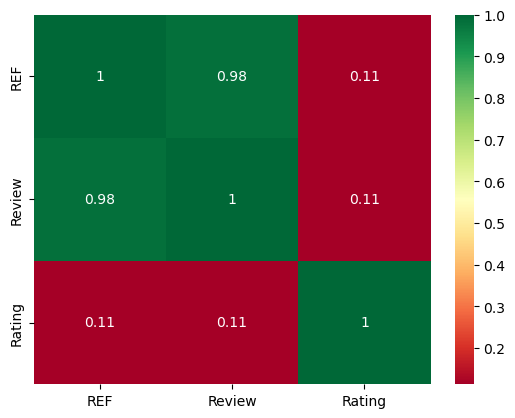

In [9]:
numeric_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(exclude=['number']).columns
sb.heatmap(data[numeric_columns].corr(), annot=True, cmap='RdYlGn')

In [10]:
XC = data.apply(lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)
cramersv.fit()

c:\Users\kuche\anaconda3\Lib\site-packages\association_metrics\categorical.py:100: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.matrix[x][y] = 1
c:\Users\kuche\anaconda3\Lib\site-packages\association_metrics\categorical.py:104: FutureW

,Company,Specific Bean Origin,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.771180,0.631741,0.999651,0.616975,0.607303
Specific Bean Origin,0.771180,1.000000,0.773074,0.808513,0.907951,0.983334
Cocoa Percent,0.631741,0.773074,1.000000,0.243831,0.158698,0.266361
Company Location,0.999651,0.808513,0.243831,1.000000,0.291667,0.383039
Bean Type,0.616975,0.907951,0.158698,0.291667,1.000000,0.388294
Broad Bean Origin,0.607303,0.983334,0.266361,0.383039,0.388294,1.000000


Удаляем столбцы 'Company Location' и 'Review', так как они не информативны

In [11]:
data.drop(['Specific Bean Origin', 'Review'], axis = 1, inplace = True)

In [12]:
numeric_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(exclude=['number']).columns

REF


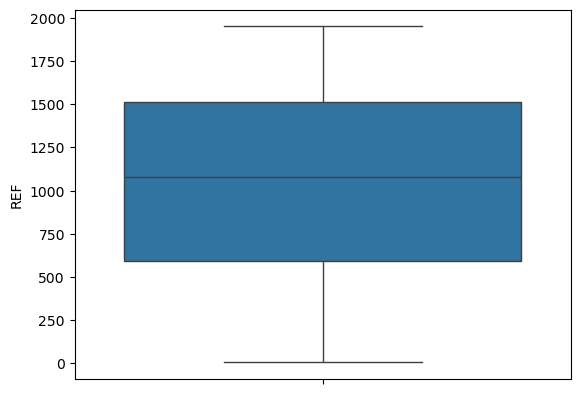

Rating


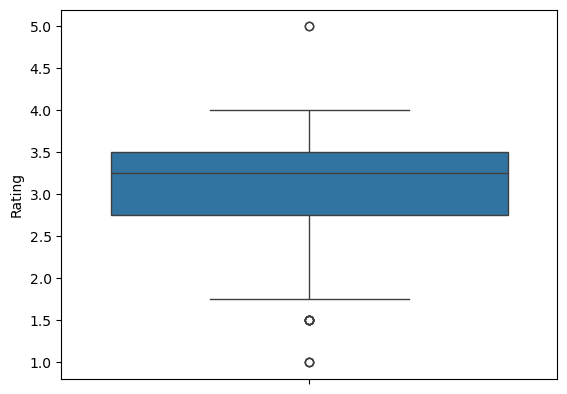

In [13]:
for column in numeric_columns:
    print(column)
    sb.boxplot(data[column])
    plt.show()

Избавляемся от выбросов в целевой переменной

In [14]:
data = data.loc[(data['Rating'] > 1.5) & (data['Rating'] < 5)]

In [15]:
for c in data.columns:
    print(c, len(data[data[c] == '\xa0']))

Company 0
REF 0
Cocoa Percent 0
Company Location 0
Rating 0
Bean Type 621
Broad Bean Origin 49


In [16]:
data['Broad Bean Origin'] = data['Broad Bean Origin'].replace('\xa0', 'Without')

In [17]:
data['Bean Type'] = data['Bean Type'].replace('\xa0', 'Without')
data['Bean Type'].value_counts()

Bean Type
Without                     621
Trinitario                  283
Criollo                     104
Forastero                    52
Forastero (Nacional)         34
Criollo, Trinitario          32
Forastero (Arriba)           30
Blend                        27
Criollo (Porcelana)           9
Forastero (Parazinho)         8
Forastero (Arriba) ASS        6
Trinitario, Criollo           3
Nacional (Arriba)             3
Forastero (Catongo)           2
Criollo, Forastero            2
Criollo (Amarru)              2
Trinitario, Forastero         2
Trinitario (Amelonado)        1
Amazon mix                    1
Trinitario, Nacional          1
Forastero (Amelonado)         1
Criollo (Ocumare 67)          1
Blend-Forastero,Criollo       1
Forastero, Trinitario         1
Criollo (Ocumare 61)          1
Trinitario (85% Criollo)      1
EET                           1
Amazon                        1
Criollo (Wild)                1
Matina                        1
Criollo, +                    

In [18]:
data['Broad Bean Origin'].value_counts()

Broad Bean Origin
Venezuela               143
Ecuador                 139
Peru                    121
Dominican Republic      104
Madagascar              103
                       ... 
Peru, Belize              1
Principe                  1
Venezuela, Ghana          1
Ven.,Ecu.,Peru,Nic.       1
Venezuela, Carribean      1
Name: count, Length: 83, dtype: int64

In [19]:
data['Broad Bean Origin'] = data['Broad Bean Origin'].replace('\xa0', -999)

In [20]:
data['Cocoa Percent'] = data['Cocoa Percent'].apply(lambda x: float(x[0:-1]))

Заменяю столбец 'Cocoa Percent' на категориальный следующим образом
от 90 до 100 - очень темный шоколад
от 70 до 90 - горький
от 53 до 70 -темный
меньше 53 - молочный

In [21]:

data['Cocoa Percent'] = data['Cocoa Percent'].replace(np.arange(90, 100.5, 0.5), 'Ultra Dark')
data['Cocoa Percent'] = data['Cocoa Percent'].replace(np.arange(70, 90, 0.5), 'Bitter')
data['Cocoa Percent'] = data['Cocoa Percent'].replace(np.arange(53, 70, 0.5), 'Dark')
data['Cocoa Percent'] = data['Cocoa Percent'].replace(np.arange(0, 53, 0.5), 'Milk')
data = data.loc[data['Cocoa Percent'] != 'Milk']
# Убираем молочный шоколад, так как его всего 2

In [22]:
data = pd.get_dummies(data, columns = ['Cocoa Percent'])

In [23]:
categorical_columns = data.select_dtypes(exclude=['number']).columns

В столбце заменяю те записи, в которых несколько стран пречислены через запятую и точку с запятой на 'Combined'

In [24]:
data['Broad Bean Origin'] = data['Broad Bean Origin'].apply(lambda x: 'Combined' if len(x.split(", ")) >= 2 or len(x.split("., ")) >= 2 else x)

In [25]:
arr = sorted(pd.cut(data['REF'], 12 * 2).unique())
data['REF'] = pd.cut(data['REF'], 12 * 2, labels=range(12 * 2))

Выделяем матрицу объект-признак и вектор с целевой переменной

In [26]:
X = data.drop('Rating', axis=1)
y = data['Rating']

## Обучение модели

Устанавливаем катбуст и обучаем его с гиперпараметрами по умолчанию на всех данных

In [27]:

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [28]:
# train_df_clean.dtypes

In [29]:
# cat_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype.name in ['category', 'object']]

# for col in X_train.drop(X_train.columns[cat_features], axis=1):
#     print(col)
#     sns.boxplot(X_train[col])
#     plt.show()
# print('Target')
# sns.boxplot(y)
# plt.show()

In [30]:
for RANDOM_STATE in range(50, 251, 50):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    cat_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype.name in ['category', 'object']]
    model = CatBoostRegressor(cat_features=cat_features)
    model.fit(X_train, y_train, verbose=False)
    print(model.score(X_train, y_train))
    pred = model.predict(X_val)

    print(r2_score(y_val, pred))

0.4713593747860788
0.16541610913121696
0.5282351306282349
0.13328486458216604
0.48547474278556313
0.1229414804803125
0.4624442232974352
0.08662553782684168
0.4636507518930362
0.18738729357537864


In [31]:
stop

NameError: name 'stop' is not defined

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1500),
        'max_depth': trial.suggest_int('depth', 2, 16),
        'verbose': 0,
        'early_stopping_rounds': 50
    }

    estimator = CatBoostRegressor(**params, cat_features=cat_features)
    estimator.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    return cross_val_score(estimator, X_train, y_train, cv=3, scoring='r2', n_jobs=5).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)
print(study.best_trial)

[I 2025-05-09 21:41:58,728] A new study created in memory with name: no-name-dab9bc1d-35a4-4df6-8ae1-2c02387cd312
[I 2025-05-09 21:52:14,737] Trial 0 finished with value: 0.06936963060427696 and parameters: {'learning_rate': 0.1873779640615753, 'n_estimators': 1201, 'depth': 14}. Best is trial 0 with value: 0.06936963060427696.
[I 2025-05-09 21:52:22,732] Trial 1 finished with value: 0.06792876272525043 and parameters: {'learning_rate': 0.0778064575119498, 'n_estimators': 268, 'depth': 7}. Best is trial 0 with value: 0.06936963060427696.
[I 2025-05-09 21:52:36,640] Trial 2 finished with value: 0.00356720006652389 and parameters: {'learning_rate': 0.11688005603918067, 'n_estimators': 531, 'depth': 7}. Best is trial 0 with value: 0.06936963060427696.
[I 2025-05-09 21:52:38,437] Trial 3 finished with value: 0.08537361537096921 and parameters: {'learning_rate': 0.010316898198902703, 'n_estimators': 194, 'depth': 2}. Best is trial 3 with value: 0.08537361537096921.
[I 2025-05-09 21:52:43,46

FrozenTrial(number=4, state=1, values=[0.11352088184920832], datetime_start=datetime.datetime(2025, 5, 9, 21, 52, 38, 437835), datetime_complete=datetime.datetime(2025, 5, 9, 21, 52, 43, 465536), params={'learning_rate': 0.035366012413945686, 'n_estimators': 422, 'depth': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=1500, log=False, low=10, step=1), 'depth': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=4, value=None)


In [ ]:
hyper_param_model = CatBoostRegressor(**study.best_params, cat_features=cat_features, verbose=False)
hyper_param_model.fit(X_train, y_train)
cb_test_pred = hyper_param_model.predict(X_val)
r2_score(y_val, cb_test_pred)
# 0.22796892470738905

0.2065745930657895

In [ ]:
cb_train_pred = hyper_param_model.predict(X_train)
r2_score(y_train, cb_train_pred)
# 0.3794773884333069

0.3984330430979799

In [ ]:
hyper_param_model.score(X_train, y_train)
# 0.3794773884333069

0.3984330430979799

In [ ]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

X_train[cat_cols] = X_train[cat_cols].astype('object')
X_val[cat_cols] = X_val[cat_cols].astype('object')

In [ ]:
cat_cols

Index(['Company', 'REF', 'Company Location', 'Bean Type', 'Broad Bean Origin'], dtype='object')

In [ ]:
p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p2 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p3 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p4 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p5 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=10)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p6 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p7 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p8 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p9 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_estimators=15, n_jobs=-1))
    ])

for i, p in enumerate([p1,p2,p3,p4,p5,p6,p7,p8,p9]):
    p.fit(X_train, y_train)
    pred = p.predict(X_val)
    print(i + 1, r2_score(y_val, pred))

1 0.13839692121278824
2 0.07479296609331298
3 0.12415405370680899
4 0.0747929660933132
5 0.13839692121278857
6 0.12415405370680921
7 0.1597178044686497
8 0.15971780446864958
9 0.05070675343879261


In [ ]:
p11 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_estimators=5, max_depth=3, random_state=42))
    ])

p12 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_estimators=10, max_depth=4, random_state=42))
    ])

p13 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_estimators=15, max_depth=6, random_state=42))
    ])

p14 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42))
    ])

p15 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=10)),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_estimators=5, max_depth=3, random_state=42))
    ])

p16 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_estimators=11, max_depth=3, random_state=42))
    ])

p17 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_estimators=20, max_depth=3, random_state=42))
    ])

p18 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_estimators=22, max_depth=4, random_state=42))
    ])

for i, p in enumerate([p11,p12,p13,p14,p15,p16,p17,p18]):
    p.fit(X_train, y_train)
    pred = p.predict(X_val)
    print(i + 1, r2_score(y_val, pred))

1 0.09226589295702448
2 0.21430447240122819
3 0.12483545715586497
4 0.1559370539427204
5 0.09226589295702448
6 0.12438173834891086
7 -0.06378783534130394
8 -0.0160911878202723


In [ ]:
lr_pred = p12.predict(X_val)

final_pred = 0.8 * cb_test_pred + 0.2 * lr_pred

r2_score(y_val, final_pred)

0.23052004875154097

Делаю обработку и предсказания на тестовых данных

In [ ]:
test_data = pd.read_csv(TEST)

In [ ]:
for c in test_data.columns:
    print(c, len(test_data[test_data[c] == '\xa0']))

Company 0
Specific Bean Origin 0
REF 0
Review 0
Cocoa Percent 0
Company Location 0
Bean Type 259
Broad Bean Origin 18


In [ ]:
test_data.drop(['Specific Bean Origin', 'Review'], axis = 1, inplace = True)

In [ ]:
test_data['Cocoa Percent'] = test_data['Cocoa Percent'].apply(lambda x: float(x[0:-1]))

In [ ]:
# test_data.drop(['Company Location'], axis = 1, inplace = True)
# test_data['Cocoa Percent'] = test_data['Cocoa Percent'].apply(lambda x: float(x[0:-1]))
test_data['Cocoa Percent'] = test_data['Cocoa Percent'].replace(np.arange(90, 100.5, 0.5), 'Ultra Dark')
test_data['Cocoa Percent'] = test_data['Cocoa Percent'].replace(np.arange(70, 90, 0.5), 'Bitter')
test_data['Cocoa Percent'] = test_data['Cocoa Percent'].replace(np.arange(53, 70, 0.5), 'Dark')
test_data['Cocoa Percent'] = test_data['Cocoa Percent'].replace(np.arange(0, 53, 0.5), 'Milk')


In [ ]:
test_data['Broad Bean Origin'] = test_data['Broad Bean Origin'].apply(lambda x: 'Combined' if len(x.split(", ")) >= 2 or len(x.split("., ")) >= 2 else x)

In [ ]:
test_data['Broad Bean Origin'] = test_data['Broad Bean Origin'].replace('\xa0', 'Venezuela')

In [ ]:
def REF_transform(x):
    for n, inerval in enumerate(arr, 1):
        if x in inerval:
            return n
        
test_data['REF'] = test_data['REF'].apply(REF_transform)

In [ ]:
test_data = pd.get_dummies(test_data, columns = ['Cocoa Percent'])

In [ ]:
test_data = test_data.drop('Cocoa Percent_Milk', axis=1)

In [ ]:
X_train.head(1)

,Company,REF,Company Location,Bean Type,Broad Bean Origin,Cocoa Percent_Bitter,Cocoa Percent_Dark,Cocoa Percent_Ultra Dark
765,Vicuna,18,U.S.A.,Without,Bolivia,True,False,False


In [ ]:
test_data.head(1)

,Company,REF,Company Location,Bean Type,Broad Bean Origin,Cocoa Percent_Bitter,Cocoa Percent_Dark,Cocoa Percent_Ultra Dark
0,Ohiyo,20,U.S.A.,Trinitario,Trinidad,True,False,False


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Company                   540 non-null    object
 1   REF                       540 non-null    int64 
 2   Company Location          540 non-null    object
 3   Bean Type                 540 non-null    object
 4   Broad Bean Origin         540 non-null    object
 5   Cocoa Percent_Bitter      540 non-null    bool  
 6   Cocoa Percent_Dark        540 non-null    bool  
 7   Cocoa Percent_Ultra Dark  540 non-null    bool  
dtypes: bool(3), int64(1), object(4)
memory usage: 22.8+ KB


In [ ]:
y_pred = hyper_param_model.predict(test_data)
lr_pred = p12.predict(test_data)
y_pred_2 = 0.8* y_pred + 0.2 * lr_pred

Делаем предсказание

In [ ]:
for i,j in zip(hyper_param_model.feature_names_, hyper_param_model.feature_importances_):
  print(i, j)

Company 37.59010987243796
REF 20.66626123404656
Company Location 10.694126674356898
Bean Type 13.642162460257913
Broad Bean Origin 9.524137972265784
Cocoa Percent_Bitter 0.14277742886464145
Cocoa Percent_Dark 1.348618727534898
Cocoa Percent_Ultra Dark 6.391805630235385


Сохраняем предсказание в файл в нужном формате

In [ ]:
test_data['id'] = np.arange(len(test_data))
test_data['Rating'] = y_pred_2

test_data[['id','Rating']].to_csv("choko_submission_6.csv", index=False)